In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")

In [2]:
import argparse
import dataclasses
import json
import logging
import math
import pathlib
import random
from copy import deepcopy


import torch
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from xopen import xopen

In [3]:
from lost_in_the_middle.prompting import (
    Document,
    get_closedbook_qa_prompt,
    get_qa_prompt,
)

# get_qa_response_from_mpt.py

In [25]:
def random_ordering(documents):
    # Randomly order only the distractors (isgold is False), keeping isgold documents
    # at their existing index.
    (original_gold_index,) = [idx for idx, doc in enumerate(documents) if doc.isgold is True]
    original_gold_document = documents[original_gold_index]
    distractors = [doc for doc in documents if doc.isgold is False]
    random.shuffle(distractors)
    distractors.insert(original_gold_index, original_gold_document)
    documents = distractors
    return documents

### Reposition function

In [139]:
def reposition(idx, acc): 
    df = pd.DataFrame({"original_position":idx, "acc":acc})
    df = df.sort_values("acc")[::-1]
    df["original_position"] = df["original_position"].astype("int")
    df["new_position"] = np.sort(df["original_position"])
    return df

df.to_csv("../qa_predictions/res_csv.csv")

Gold Index 0:
best_subspan_em: 0.536723163841808

Gold Index 4:
best_subspan_em: 0.5175141242937853

Gold Index 9:
best_subspan_em: 0.5216572504708098

Gold Index 14:
best_subspan_em: 0.5265536723163842

Gold Index 19:
best_subspan_em: 0.5623352165725047

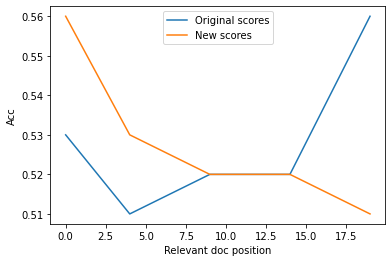

In [105]:
# Initialize scores and idx
acc_scores = acc

# Reposition indx and scores
df = reposition(idx, acc_scores)

# Plot results
plt.plot(df.original_position.sort_values(), df["acc"].values[np.argsort(df.original_position.values)], label="Original scores")

plt.plot(df.new_position.sort_values(), df["acc"].values[np.argsort(df.new_position.values)], label="New scores")
plt.ylabel("Acc")
plt.xlabel("Relevant doc position")
plt.legend()
plt.show()

In [100]:
df

,original_position,acc,new_position
4,19,0.56,0
0,0,0.53,4
3,14,0.52,9
2,9,0.52,14
1,4,0.51,19


In [135]:
def reordering(documents, reorder_df):
    new_documents = documents.copy()
    original_positions = reorder_df["original_position"].values
    new_positions = reorder_df["new_position"].values
    # Reorder the documents of interest from their original to their new positions
    for i, pos in enumerate(new_positions):
        new_documents[pos] = documents[original_positions[i]]
    return new_documents

In [136]:
idx = [0,4,9,14,19]
acc = [0.53, 0.51, 0.52, 0.52, 0.56]
reorder_df = reposition(idx, acc)
reorder_df

,original_position,acc,new_position
4,19,0.56,0
0,0,0.53,4
3,14,0.52,9
2,9,0.52,14
1,4,0.51,19


In [137]:
def main(
    input_path,
    model_name,
    temperature,
    top_p,
    batch_size,
    closedbook,
    prompt_mention_random_ordering,
    use_random_ordering,
    query_aware_contextualization,
    num_gpus,
    max_memory_per_gpu,
    max_new_tokens,
    output_path,
    reordering_df=None,
):
    # Create directory for output path if it doesn't exist.
    pathlib.Path(output_path).parent.mkdir(parents=True, exist_ok=True)

    examples = []
    prompts = []
    all_model_documents = []
    did_format_warn = False

    # Fetch all of the prompts
    with xopen(input_path) as fin:
        for line in tqdm(fin):
            input_example = json.loads(line)
            # Get the prediction for the input example
            question = input_example["question"]
            if closedbook:
                documents = []
            else:
                documents = []
                for ctx in deepcopy(input_example["ctxs"]):
                    documents.append(Document.from_dict(ctx))
                if not documents:
                    raise ValueError(f"Did not find any documents for example: {input_example}")
            
            # Put some of the ordering here and put it in functions
            if use_random_ordering:
                documents = random_ordering(documents)
            
            if reordering_df is not None:
                old_docs = [doc.title for doc in documents]
                documents = reordering(documents, reordering_df)
                new_docs = [doc.title for doc in documents]
                

            if closedbook:
                prompt = get_closedbook_qa_prompt(question)
            else:
                prompt = get_qa_prompt(
                    question,
                    documents,
                    mention_random_ordering=prompt_mention_random_ordering,
                    query_aware_contextualization=query_aware_contextualization,
                )

            if "instruct" in model_name:
                if did_format_warn is False:
                    did_format_warn = True
                prompt = format_instruct_prompt(prompt)
            prompts.append(prompt)
            examples.append(deepcopy(input_example))
            all_model_documents.append(documents)
            
            break
    """

    
    config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
    config.attn_config["attn_impl"] = "triton"
    config.max_seq_len = 16384
    # (input + output) tokens can now be up to 16384
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token  # to avoid an error
    
    responses = []
    
    for batched_prompts in tqdm(chunks(prompts, batch_size), total=math.ceil(len(prompts) / batch_size)):
        inputs = tokenizer(batched_prompts, return_tensors="pt", padding=True)
        outputs = [x[:100].split(" ") for x in batched_prompts]
        responses.append(outputs)

    with xopen(output_path, "w") as f:
        for example, model_documents, prompt, response in zip(examples, all_model_documents, prompts, responses):
            output_example = deepcopy(example)
            # Add some extra metadata to the output example
            output_example["model_prompt"] = prompt
            output_example["model_documents"] = [dataclasses.asdict(document) for document in model_documents]
            output_example["model_answer"] = output_example["answers"]
            #output_example["model_answer"] = response
            output_example["model"] = model_name
            output_example["model_temperature"] = temperature
            output_example["model_top_p"] = top_p
            output_example["model_prompt_mention_random_ordering"] = prompt_mention_random_ordering
            output_example["model_use_random_ordering"] = use_random_ordering
            f.write(json.dumps(output_example) + "\n")


"""
    
main(
    "../qa_data/20_total_documents/nq-open-20_total_documents_gold_at_0.jsonl.gz",
    "mosaicml/mpt-30b-instruct",
    0.0,
    1,
    1,
    False,
    False,
    False,
    True,
    1,
    40,
    100,
    "../qa_predictions/nq-open-oracle-mpt-30b-instruct-predictions.jsonl.gz",
    reorder_df
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0it [00:00, ?it/s]

False
['List of Nobel laureates in Physics', 'Asian Americans in science and technology', 'Scientist', 'Norwegian Americans', 'Maria Goeppert Mayer', 'University of Chicago', 'École normale supérieure (Paris)', 'Marie Curie', "St John's College, Cambridge", 'Arthur H. Rosenfeld', 'Japanese Americans', 'Nobel Prize in Physics', 'Paris in the Belle Époque', 'Richard Feynman', 'Marie Curie', 'E. C. George Sudarshan', 'Rosalyn Sussman Yalow', 'Poles', 'Nobel Prize', 'Charles Russell Bardeen']
['Charles Russell Bardeen', 'Asian Americans in science and technology', 'Scientist', 'Norwegian Americans', 'List of Nobel laureates in Physics', 'University of Chicago', 'École normale supérieure (Paris)', 'Marie Curie', "St John's College, Cambridge", 'Marie Curie', 'Japanese Americans', 'Nobel Prize in Physics', 'Paris in the Belle Époque', 'Richard Feynman', 'Arthur H. Rosenfeld', 'E. C. George Sudarshan', 'Rosalyn Sussman Yalow', 'Poles', 'Nobel Prize', 'Maria Goeppert Mayer']


In [138]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

In [40]:
def format_instruct_prompt(instruction):
    INSTRUCTION_KEY = "### Instruction:"
    RESPONSE_KEY = "### Response:"
    INTRO_BLURB = (
        "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    )
    PROMPT_FOR_GENERATION = "{intro}\n{instruction_key}\n{instruction}\n{response_key}\n".format(
        intro=INTRO_BLURB,
        instruction_key=INSTRUCTION_KEY,
        instruction=instruction,
        response_key=RESPONSE_KEY,
    )
    return PROMPT_FOR_GENERATION

In [41]:
main(
        "../qa_data/nq-open-oracle.jsonl.gz",
        "mosaicml/mpt-30b-instruct",
        0.0,
        1,
        1,
        False,
        False,
        True,
        True,
        1,
        40,
        100,
        "../qa_predictions/nq-open-oracle-mpt-30b-instruct-predictions.jsonl.gz",
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



0it [00:00, ?it/s]

[Document(title='List of Nobel laureates in Physics', text='The first Nobel Prize in Physics was awarded in 1901 to Wilhelm Conrad Röntgen, of Germany, who received 150,782 SEK, which is equal to 7,731,004 SEK in December 2007.  John Bardeen is the only laureate to win the prize twice—in 1956 and 1972. Maria Skłodowska-Curie also won two Nobel Prizes, for physics in 1903 and chemistry in 1911. William Lawrence Bragg was, until October 2014, the youngest ever Nobel laureate; he won the prize in 1915 at the age of 25. Two women have won the prize: Curie and Maria Goeppert-Mayer (1963). As of 2017, the prize has been awarded', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='List of Nobel laureates in Physics', text='The first Nobel Prize in Physics was awarded in 1901 to Wilhelm Conrad Röntgen, of Germany, who received 150,782 SEK, which is equal to 7,731,004 SEK in December 2007.  John Bardeen is the only laureate to win the prize twice—


158it [00:00, 1565.30it/s]

[Document(title='Gerald Ford', text="Ford was involved in the Boy Scouts of America, and earned that program's highest rank, Eagle Scout.  He is the only Eagle Scout to have ascended to the U.S. Presidency.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Gerald Ford', text="Ford was involved in the Boy Scouts of America, and earned that program's highest rank, Eagle Scout.  He is the only Eagle Scout to have ascended to the U.S. Presidency.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='U.S. history of alcohol minimum purchase age by state', text='voluntarily raised their purchase ages to 19 (or, less commonly, 20 or 21), in part to combat drunk driving fatalities. In 1984, Congress passed the National Minimum Drinking Age Act, which required states to raise their ages for purchase and public possession to 21 by October 1986 or lose 10% of their federal highway funds. By mid-1988,


315it [00:00, 1397.65it/s]

[Document(title='List of sitting judges of the Supreme Court of India', text='This is a list of judges of the Supreme Court of India, the highest court in the Republic of India. The list is ordered according to seniority. There are currently 24 judges, against a maximum possible strength of 31.  As per the Constitution of India, judges of the Supreme Court judges retire at age 65.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='List of sitting judges of the Supreme Court of India', text='This is a list of judges of the Supreme Court of India, the highest court in the Republic of India. The list is ordered according to seniority. There are currently 24 judges, against a maximum possible strength of 31.  As per the Constitution of India, judges of the Supreme Court judges retire at age 65.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Just When I Needed You Most', text='"Just When 


456it [00:00, 1266.24it/s]

[Document(title='Loyola University Chicago', text="LU Wolf is the mascot for the University. He was inspired by the coat-of-arms of St. Ignatius of Loyola, from whom Loyola derives its name, which depicts two wolves standing over a kettle.  Taken from the heraldic crest carved in the lintel on St. Ignatius' family home in Azpeitia, Spain, the wolves and cauldron refer to the prosperity and generosity of the Loyola family, who, after feeding family, retainers and soldiers, had enough food to feed even the wild animals.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Loyola University Chicago', text="LU Wolf is the mascot for the University. He was inspired by the coat-of-arms of St. Ignatius of Loyola, from whom Loyola derives its name, which depicts two wolves standing over a kettle.  Taken from the heraldic crest carved in the lintel on St. Ignatius' family home in Azpeitia, Spain, the wolves and cauldron refer to the prosperity and


587it [00:00, 1280.23it/s]


[Document(title='List of Olympic Games host cities', text="editions of the Games were scheduled to take place but later cancelled due to war: Berlin (summer) in 1916; Tokyo/Helsinki (summer) and Sapporo/Garmisch-Partenkirchen (winter) in 1940; and London (summer) and Cortina d'Ampezzo, Italy (winter) in 1944. The 1906 Summer Olympics were officially sanctioned and held in Athens. However, in 1949, the International Olympic Committee (IOC), decided to unrecognize the 1906 Games. Four cities have been chosen by the IOC to host upcoming Olympic Games: Tokyo for the 2020 Summer Olympics, Beijing for the 2022 Winter Olympics, Paris for the 2024 Summer Olympics, and Los Angeles for the 2028 Summer Olympics.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Heaven (Los Lonely Boys song)', text='"Heaven" is the debut single of American rock band Los Lonely Boys.  The song was written by brothers Henry, Jojo and Ringo Garza, who comprise the f


716it [00:00, 1128.20it/s]

[Document(title='Egypt Eyalet', text='Husrev Pasha was the first Ottoman governor of Egypt after the expulsion of the French.  The form of government, however, was not the same as that before the French invasion, for the Mamluks were not reinstated. The pasha, and through him the Sultan, repeatedly tried to either ensnare them or to beguile them into submission. These efforts failing, Husrev took the field and a Turkish detachment 7,000 strong was dispatched against the Mamluks to Damanhur—whence they had descended from Upper Egypt—and was defeated by a small force under either al-Alfi or his lieutenant al-Bardisi. Their ammunition and guns fell into', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Egypt Eyalet', text='Husrev Pasha was the first Ottoman governor of Egypt after the expulsion of the French.  The form of government, however, was not the same as that before the French invasion, for the Mamluks were not reinstated. The pas

[Document(title='Subdural hematoma', text='A subdural hematoma (SDH), is a type of hematoma, usually associated with traumatic brain injury. Blood gathers between the inner layer of the dura mater and the arachnoid mater. Usually resulting from tears in bridging veins which cross the subdural space, subdural hemorrhages may cause an increase in intracranial pressure (ICP), which can cause compression of and damage to delicate brain tissue. Subdural hematomas are often life-threatening when acute. Chronic subdural hematomas, however, have a better prognosis if properly managed.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Subdural hematoma', text='A subdural hematoma (SDH), is a type of hematoma, usually associated with traumatic brain injury. Blood gathers between the inner layer of the dura mater and the arachnoid mater. Usually resulting from tears in bridging veins which cross the subdural space, subdural hemorrhages may cause 


832it [00:00, 851.61it/s] 

[Document(title='Diana Rigg', text="The same year, Rigg secured a recurring role in the third season of the HBO series Game of Thrones, portraying Lady Olenna Tyrell, a witty and sarcastic political mastermind popularly known as the Queen of Thorns, the grandmother of regular character Margaery Tyrell. Her performance was well received by critics and audiences alike, and earned her an Emmy nomination for Outstanding Guest Actress in a Drama Series for the 65th Primetime Emmy Awards in 2013. She reprised her role in season four of Game of Thrones, and in July 2014 received another Guest Actress Emmy nomination. In 2015 and 2016, she again reprised the role in seasons five and six in an expanded role from the books. The character was finally killed off in the seventh season, with Rigg's final performance receiving critical acclaim.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='The Ten Commandments (1956 film)', text='biblical story o


974it [00:00, 987.88it/s]


[Document(title='Mercy Mercy Me (The Ecology)', text='"Mercy Mercy Me (The Ecology)" was the second single from Marvin Gaye\'s 1971 album, What\'s Going On. Following the breakthrough of the title track\'s success, the song, written solely by Gaye, became regarded as one of popular music\'s most poignant anthems of sorrow regarding the environment.  Led by Gaye playing piano, strings conducted by Paul Riser and David Van De Pitte, multi-tracking vocals from Gaye and The Andantes, multiple background instruments provided by The Funk Brothers and a leading sax solo by Wild Bill Moore, the song rose to number 4 on Billboard\'s Pop Singles chart and number one for', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Mercy Mercy Me (The Ecology)', text='"Mercy Mercy Me (The Ecology)" was the second single from Marvin Gaye\'s 1971 album, What\'s Going On. Following the breakthrough of the title track\'s success, the song, written solely by Gay

[Document(title='Pint glass', text='beer must be sold in Imperial measure (see Pint § Effects of metrication). United Kingdom law requires certain steps be taken to ensure that a pint of beer is indeed a pint. Though this can be achieved using "metered dispense" (calibrated pumps), the more common solution is to use certified one-pint glasses. Until recently these had a crown stamp indicating that the certification had been done by an agency of the Crown. The number etched upon the glasses stands for the manufacturing company or site.  Most pint glasses used in the United Kingdom today have actually been produced in France.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Pint glass', text='beer must be sold in Imperial measure (see Pint § Effects of metrication). United Kingdom law requires certain steps be taken to ensure that a pint of beer is indeed a pint. Though this can be achieved using "metered dispense" (calibrated pumps), t


1085it [00:01, 841.35it/s]

[Document(title='0', text="The rules governing the use of zero appeared for the first time in Brahmagupta's Brahmasputha Siddhanta (7th\xa0century).  This work considers not only zero, but negative numbers, and the algebraic rules for the elementary operations of arithmetic with such numbers. In some instances, his rules differ from the modern standard, specifically the definition of the value of zero divided by zero as zero.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='0', text="The rules governing the use of zero appeared for the first time in Brahmagupta's Brahmasputha Siddhanta (7th\xa0century).  This work considers not only zero, but negative numbers, and the algebraic rules for the elementary operations of arithmetic with such numbers. In some instances, his rules differ from the modern standard, specifically the definition of the value of zero divided by zero as zero.", id=None, score=None, hasanswer=True, isgold=True, orig


1227it [00:01, 974.92it/s]

[Document(title='Joseph N. Welch', text='Joseph Nye Welch (October 22, 1890 – October 6, 1960) was an American lawyer who served as the chief counsel for the United States Army while it was under investigation for Communist activities by Senator Joseph McCarthy\'s Senate Permanent Subcommittee on Investigations, an investigation known as the Army–McCarthy hearings.  His confrontation with McCarthy during the hearings, in which he famously asked McCarthy "At long last, have you left no sense of decency?" is seen as a turning point in the history of McCarthyism.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Joseph N. Welch', text='Joseph Nye Welch (October 22, 1890 – October 6, 1960) was an American lawyer who served as the chief counsel for the United States Army while it was under investigation for Communist activities by Senator Joseph McCarthy\'s Senate Permanent Subcommittee on Investigations, an investigation known as the Army–


1355it [00:01, 1049.00it/s]


[Document(title='Santería', text="To begin with, the initiator goes through what is called a cleansing ritual. The initiator's Padrino (godfather) cleanses the head with special herbs and water. The Padrino rubs the herbs and water in a specific pattern of movements into the scalp of the head. However, if a person is entering Santería for the need of healing, they will undergo the rogación de la cabeza (blessing of the head), in which coconut water and cotton are applied on the head to feed it. Once cleansed, there are four major initiation rituals that the initiator will have to undergo: obtaining the elekes (beaded necklace), receiving Los Guerreros (the Warriors), making Ochá (Saint), and Asiento (ascending the throne).", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='2014 Winter Paralympics', text='Brazil, Turkey and Uzbekistan made their Winter Paralympic debut in Sochi, while Hungary and South Africa, who participated in Vancou


1470it [00:01, 1056.02it/s]

[Document(title='World Series', text="The World Series is the annual championship series of Major League Baseball (MLB) in North America, contested since 1903 between the American League (AL) champion team and the National League (NL) champion team. The winner of the World Series championship is determined through a best-of-seven playoff, and the winning team is awarded the Commissioner's Trophy.  As the series is played during the fall season in North America, it is sometimes referred to as the Fall Classic.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='World Series', text="The World Series is the annual championship series of Major League Baseball (MLB) in North America, contested since 1903 between the American League (AL) champion team and the National League (NL) champion team. The winner of the World Series championship is determined through a best-of-seven playoff, and the winning team is awarded the Commissioner's Trophy.  


1583it [00:01, 1033.99it/s]

[Document(title='Junie B. Jones', text='Junie B. Jones is a children\'s book series written by Barbara Park and illustrated by Denise Brunkus. Published by Random House from 1992 to 2013, the stories begin with Junie B. Jones and the Stupid Smelly Bus, in which Junie B. is an "almost six year old" starting her first day of kindergarten.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Junie B. Jones', text='Junie B. Jones is a children\'s book series written by Barbara Park and illustrated by Denise Brunkus. Published by Random House from 1992 to 2013, the stories begin with Junie B. Jones and the Stupid Smelly Bus, in which Junie B. is an "almost six year old" starting her first day of kindergarten.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='The Good Doctor (TV series)', text='The series stars Freddie Highmore as Shaun Murphy, a young surgical resident with autism and savant s


1696it [00:01, 1057.65it/s]

[Document(title='Uniformitarianism', text='"the present is the key to the past" (that events occur at the same rate now as they have always done); many geologists now, however, no longer hold to a strict theory of gradualism. Coined by William Whewell, the word was proposed in contrast to catastrophism by British naturalists in the late 18th century, starting with the work of the geologist James Hutton.  Hutton\'s work was later refined by scientist John Playfair and popularised by geologist Charles Lyell\'s Principles of Geology in 1830. Today, Earth\'s history is considered to have been a slow, gradual process, punctuated by occasional natural catastrophic', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Uniformitarianism', text='"the present is the key to the past" (that events occur at the same rate now as they have always done); many geologists now, however, no longer hold to a strict theory of gradualism. Coined by William Whewe


1806it [00:01, 1055.13it/s]


[Document(title='Prudential Center', text='Prudential Center is a multi-purpose indoor arena in the central business district of Newark, New Jersey, United States. It was designed by HOK Sport (now Populous), with the exterior designed by Morris Adjmi Architects. Opened in 2007, it is the home of the New Jersey Devils of the National Hockey League (NHL) and the Seton Hall Pirates men\'s basketball team from Seton Hall University.  The arena seats 16,514 patrons for hockey and 18,711 for basketball. Fans and sports writers have affectionately nicknamed the arena "The Rock" in reference to the Rock of Gibraltar, the corporate logo of Prudential Financial, a', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Climate of Asia', text='Around September, with the sun fast retreating south, the northern land mass of the Indian subcontinent begins to cool off rapidly. With this air pressure begins to build over northern India, the Indian Ocean a


1921it [00:01, 1078.36it/s]

[Document(title='Acetate', text='An acetate /ˈæsɪteɪt/ is a salt formed by the combination of acetic acid with an alkaline, earthy, or metallic base. "Acetate" also describes the conjugate base or ion (specifically, the negatively charged ion called an anion) typically found in aqueous solution and written with the chemical formula C2H3O2. The neutral molecules formed by the combination of the acetate ion and a positive ion (called a cation) are also commonly called "acetates" (hence, acetate of lead, acetate of aluminum, etc.). The simplest of these is hydrogen acetate (called acetic acid) with corresponding salts, esters, and the polyatomic anion CH3CO2, or CH3COO.', id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Acetate', text='An acetate /ˈæsɪteɪt/ is a salt formed by the combination of acetic acid with an alkaline, earthy, or metallic base. "Acetate" also describes the conjugate base or ion (specifically, the negatively charged i


2031it [00:01, 1075.64it/s]

[Document(title='Camilla Luddington', text="joined the cast of the Showtime comedy-drama series Californication for its fifth season, playing a nanny. She also joined the cast of season five of the HBO vampire drama True Blood, as Claudette Crane, a faerie. In July 2012, Luddington joined the cast of Grey's Anatomy as Dr. Jo Wilson in a recurring role. In June 2013 it was announced that she would be a series regular from season ten onward. In October 2012, Camilla appeared on a Halloween special of E!'s popular fashion programme, Fashion Police, alongside a panel of Joan Rivers, Kelly Osbourne, George Kotsiopoulos and Kris Jenner.", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Camilla Luddington', text="joined the cast of the Showtime comedy-drama series Californication for its fifth season, playing a nanny. She also joined the cast of season five of the HBO vampire drama True Blood, as Claudette Crane, a faerie. In July 2012, Luddi


2140it [00:02, 1073.43it/s]

[Document(title='History of Vietnam', text="Full-scale war broke out between the Việt Minh and France in late 1946 and the First Indochina War officially began. Realizing that colonialism was coming to an end worldwide, France decided to bring former emperor Bảo Đại back to power, as a political alternative to Ho Chi Minh. A Provisional Central Government was formed in 1948, reuniting Annam and Tonkin, but the complete reunification of Vietnam was delayed for a year because of the problems posed by Cochinchina's legal status. In July 1949, the State of Vietnam was officially proclaimed, as a semi-independent country within the French Union, with Bảo Đại as Head of State. France was finally persuaded to relinquish its colonies in Indochina in 1954 when Viet Minh forces defeated the French at Dien Bien Phu. ", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='History of Vietnam', text="Full-scale war broke out between the Việt Minh and Fra


2280it [00:02, 1167.38it/s]


[Document(title='Gabbar Is Back', text="Gabbar Is Back is a 2015 Indian vigilante film directed by Krish and produced by Sanjay Leela Bhansali and Viacom 18 Motion Pictures. Featuring Akshay Kumar and Shruti Haasan in the lead roles, the film is a remake of the 2002 Tamil film Ramanaa, directed by A. R. Murugadoss, which was later remade in Telugu as Tagore in 2003 and in Kannada as Vishnu Sena in 2005.  Suman Talwar, Sunil Grover and Jaideep Ahlawat appear in supporting roles with Kareena Kapoor Khan in a cameo. The movie has garnered a good box office success and Akshay Kumar's acting was critically", id=None, score=None, hasanswer=True, isgold=True, original_retrieval_index=None)]
[Document(title='Geraldine Ferraro', text="In 1984, former vice president and presidential candidate Walter Mondale, seen as an underdog, selected Ferraro to be his running mate in the upcoming election. Ferraro became the only Italian American to be a major-party national nominee in addition to being the

2408it [00:02, 1198.51it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# evaluate_qa_responses.py

In [30]:
import statistics

from lost_in_the_middle.metrics import best_subspan_em

In [31]:
METRICS = [
    (best_subspan_em, "best_subspan_em"),
]

In [32]:
METRICS

[(<function lost_in_the_middle.metrics.best_subspan_em(prediction: str, ground_truths: List[str]) -> float>,
  'best_subspan_em')]

In [36]:
def main(
    input_path,
    output_path,
):
    all_examples = []
    with xopen(input_path) as fin:
        for line in tqdm(fin):
            input_example = json.loads(line)
            all_examples.append(input_example)

    # Compute normal metrics in parallel, if applicable
    all_example_metrics = []
    for example in tqdm(all_examples):
        all_example_metrics.append(get_metrics_for_example(example))

    # Average metrics across examples
    for (_, metric_name) in METRICS:
        average_metric_value = statistics.mean(
            example_metrics[metric_name] for (example_metrics, _) in all_example_metrics
        )
        print(f"{metric_name}: {average_metric_value}")

    if output_path:
        with xopen(output_path, "w") as f:
            for (example_metrics, example) in all_example_metrics:
                example_with_metrics = deepcopy(example)
                for metric_name, metric_value in example_metrics.items():
                    example_with_metrics[f"metric_{metric_name}"] = metric_value
                f.write(json.dumps(example_with_metrics) + "\n")


In [37]:
def get_metrics_for_example(example):
    gold_answers = example["answers"]
    model_answer = example["model_answer"]

    # NOTE: we take everything up to the first newline, since otherwise models could hack
    # the metric by simply copying te input context (as the gold answer is guaranteed
    # to occur in the input context).
    model_answer = "; ".join(model_answer).split("\n")[0].strip()
    
    example_metrics = {}
    for (metric, metric_name) in METRICS:
        example_metrics[metric_name] = metric(prediction=model_answer, ground_truths=gold_answers)
    return (example_metrics, example)

In [38]:
main(
        "../qa_predictions/nq-open-oracle-mpt-30b-instruct-predictions.jsonl.gz",
        "../qa_predictions/nq-open-oracle-mpt-30b-instruct-predictions-scored.jsonl.gz",
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2655it [00:00, 29126.20it/s]
100%|████████████████████████████████████| 2655/2655 [00:00<00:00, 29051.05it/s]


best_subspan_em: 1.0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
